In [114]:
#| hide
!pip install -Uqq nixtla

In [115]:
#| hide 
from nixtla.utils import in_colab

In [116]:
#| hide 
IN_COLAB = in_colab()

In [117]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Holidays and special dates

Calendar variables and special dates are one of the most common types of additional variables used in forecasting applications. They provide additional context on the current state of the time series, especially for window-based models such as TimeGPT-1. These variables often include adding information on each observation's month, week, day, or hour. For example, in high-frequency hourly data, providing the current month of the year provides more context than the limited history available in the input window to improve the forecasts.

In this tutorial we will show how to add calendar variables automatically to a dataset using the `date_features` function.

In [118]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/tutorials/02_holidays')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/02_holidays.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [119]:
import pandas as pd
from nixtla import NixtlaClient

In [120]:
import os
from dotenv import load_dotenv

load_dotenv()

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = os.environ.get("NIXTLA_API_KEY")
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [121]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

We will use a Google trends dataset on chocolate, with monthly data.

In [122]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/google_trend_chocolate.csv')
df['month'] = pd.to_datetime(df['month']).dt.to_period('M').dt.to_timestamp('M')

In [123]:
df.head()

,month,chocolate
0,2004-01-31,35
1,2004-02-29,45
2,2004-03-31,28
3,2004-04-30,30
4,2004-05-31,29


## 3. Forecasting with holidays and special dates

### 3.1 Create Future DataFrame

When adding exogenous variables (like holidays) to time series forecasting, we need a future DataFrame because:

- Historical data already exists: Our training data contains past values of both the target variable and exogenous features
- Future exogenous features are known: Unlike the target variable, we can determine future values of exogenous features (like holidays) in advance

For example, we know that Christmas will occur on December 25th next year, so we can include this information in our future DataFrame to help the model understand seasonal patterns during the forecast period.

Start with a future dataframe with 14 months of data starting from May 2024.

In [124]:
# Create future dataframe for adding US holidays

start_date = '2024-05'
dates = pd.date_range(start=start_date, periods=14, freq='M')

dates = dates.to_period('M').to_timestamp('M')

future_df = pd.DataFrame(dates, columns=['month'])

/var/folders/5w/fg65_rp17lz39z89p0nkv8ch0000gn/T/ipykernel_42683/2814285053.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, periods=14, freq='M')


### 3.2 Adding Country Holidays

Before adding country holidays, let's create a function to add date features to a dataframe. This function takes:

- A pandas dataframe
- A date extractor function, which can be `CountryHolidays` or `SpecialDates`
- A time column name

In [125]:
def add_date_features_to_dataframe(df, date_extractor, time_col="month"):
    # Create a copy of the dataframe
    df = df.copy()

    # Create date range from start to end of dataframe
    dates_range = pd.date_range(
        start=df.iloc[0][time_col], end=df.iloc[-1][time_col], freq="D"
    )

    # Get date feature indicators and resample to monthly
    features_df = date_extractor(dates_range)
    monthly_features = features_df.resample("M").max()
    monthly_features = monthly_features.reset_index(names=time_col)

    # Merge with input dataframe
    result_df = df.merge(monthly_features)

    return result_df

Let's use the `CountryHolidays` extractor to add US holidays to the future dataframe.

In [126]:
# Create holiday extractor and apply to future data
from nixtla.date_features import CountryHolidays

us_holidays = CountryHolidays(countries=["US"])

future_df_holidays = add_date_features_to_dataframe(future_df, us_holidays)

print(f"Future dataframe shape: {future_df_holidays.shape}")
future_df_holidays.head()

Future dataframe shape: (14, 12)


/var/folders/5w/fg65_rp17lz39z89p0nkv8ch0000gn/T/ipykernel_42683/3962131156.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_features = features_df.resample("M").max()


,month,US_New Year's Day,US_Memorial Day,US_Juneteenth National Independence Day,US_Independence Day,US_Labor Day,US_Veterans Day,US_Thanksgiving Day,US_Christmas Day,US_Martin Luther King Jr. Day,US_Washington's Birthday,US_Columbus Day
0,2024-05-31,0,0,0,0,0,0,0,0,0,0,0
1,2024-06-30,0,0,1,0,0,0,0,0,0,0,0
2,2024-07-31,0,0,0,1,0,0,0,0,0,0,0
3,2024-08-31,0,0,0,0,0,0,0,0,0,0,0
4,2024-09-30,0,0,0,0,1,0,0,0,0,0,0


We perform the same steps for the current data.

In [127]:
# Add exogenous features to input dataframe
df_with_holidays = add_date_features_to_dataframe(df, us_holidays)

df_with_holidays.tail()

/var/folders/5w/fg65_rp17lz39z89p0nkv8ch0000gn/T/ipykernel_42683/3962131156.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_features = features_df.resample("M").max()


,month,chocolate,US_New Year's Day,US_New Year's Day (observed),US_Memorial Day,US_Independence Day,US_Independence Day (observed),US_Labor Day,US_Veterans Day,US_Thanksgiving Day,US_Christmas Day,US_Christmas Day (observed),US_Martin Luther King Jr. Day,US_Washington's Birthday,US_Columbus Day,US_Veterans Day (observed),US_Juneteenth National Independence Day,US_Juneteenth National Independence Day (observed)
239,2023-12-31,90,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
240,2024-01-31,64,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
241,2024-02-29,66,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
242,2024-03-31,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
243,2024-04-30,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Great! Now, TimeGPT will consider the holidays as exogenous variables and the upcoming holidays will help it make predictions.

In [128]:
fcst_df_holidays = nixtla_client.forecast(
    df=df_with_holidays,
    h=14,
    freq="M",
    time_col="month",
    target_col="chocolate",
    X_df=future_df_holidays,
)

INFO:nixtla.nixtla_client:Validating inputs...
/Users/khuyentran/nixtla/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla/nixtla/nixtla_client.py:400: UserWarning: `df` contains the following exogenous features: ["US_New Year's Day (observed)", 'US_Independence Day (observed)', 'US_Christmas Day (observed)', 'US_Veterans Day (observed)', 'US_Juneteenth National Independence Day (observed)'], but they were not found in `X_df` nor declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Using future exogenous features: ["US_New Year's Day", 'US_Memorial Day', 'US_Juneteenth National Independence Day', 'US_Independence Day', 'US_Labor Day', 'US_Veterans D

Plot the forecast with holidays

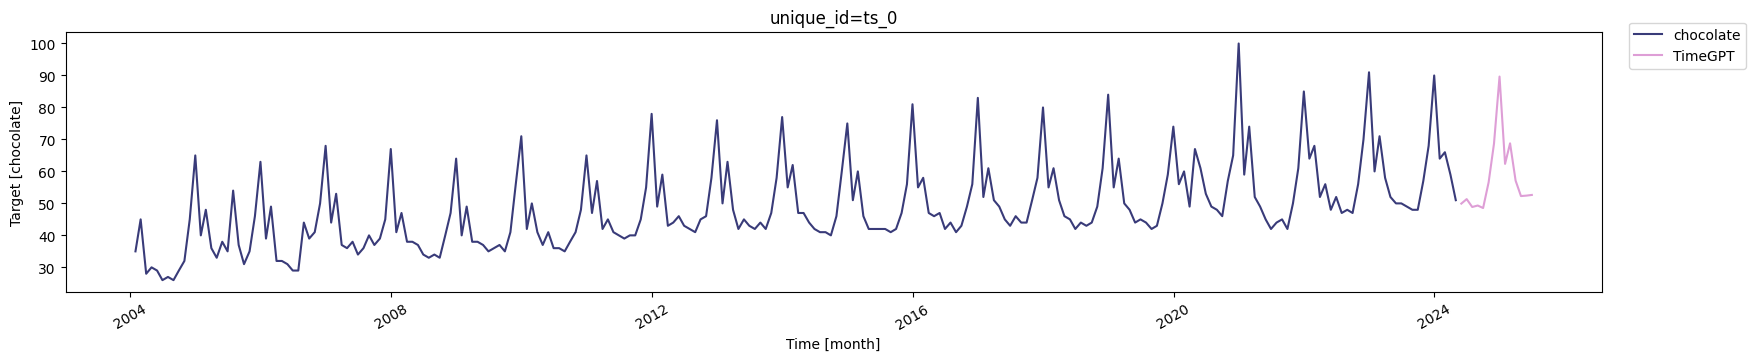

In [129]:
nixtla_client.plot(
    df_with_holidays, 
    fcst_df_holidays, 
    time_col='month',
    target_col='chocolate',
)

We can then plot the weights of each holiday to see which are more important in forecasing the interest in chocolate.

<Axes: ylabel='features'>

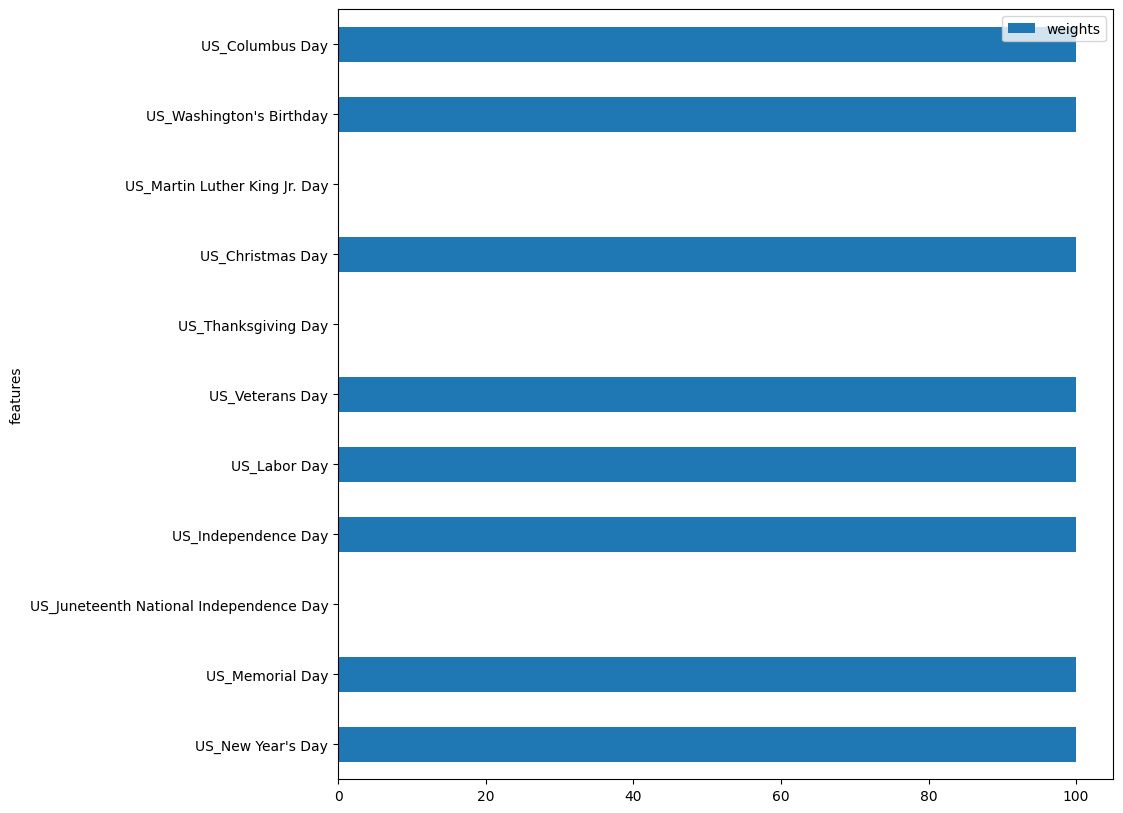

In [130]:
nixtla_client.weights_x.plot.barh(x='features', y='weights', figsize=(10, 10))

### 3.3 Adding Custom Special Dates

In addition to country holidays, you can also define your own special dates using `SpecialDates`. This is useful for marking company-specific events, product launches, promotions, or any custom dates that might affect your forecasting.

In this example, we'll use Valentine's Day and Halloween as custom special dates and add them to the future dataframe.

In [131]:
from nixtla.date_features import SpecialDates

# Generate special dates programmatically for the full data range (2004-2025)
valentine_dates = [f"{year}-02-14" for year in range(2004, 2026)]
halloween_dates = [f"{year}-10-31" for year in range(2004, 2026)]

# Define custom special dates - chocolate-related seasonal events
special_dates = SpecialDates(
    special_dates={
        "Valentine_season": valentine_dates,
        "Halloween_season": halloween_dates,
    }
)

# Apply special dates to future data
future_df_special = add_date_features_to_dataframe(future_df, special_dates)

print(f"Future dataframe shape: {future_df_special.shape}")
future_df_special.head()

Future dataframe shape: (14, 3)


/var/folders/5w/fg65_rp17lz39z89p0nkv8ch0000gn/T/ipykernel_42683/3962131156.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_features = features_df.resample("M").max()


,month,Valentine_season,Halloween_season
0,2024-05-31,0,0
1,2024-06-30,0,0
2,2024-07-31,0,0
3,2024-08-31,0,0
4,2024-09-30,0,0


We will also add custom special dates to the current dataframe.

In [132]:
# Apply special dates to historical data as well
df_special = add_date_features_to_dataframe(df, special_dates)

df_special.tail()

/var/folders/5w/fg65_rp17lz39z89p0nkv8ch0000gn/T/ipykernel_42683/3962131156.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_features = features_df.resample("M").max()


,month,chocolate,Valentine_season,Halloween_season
239,2023-12-31,90,0,0
240,2024-01-31,64,0,0
241,2024-02-29,66,1,0
242,2024-03-31,59,0,0
243,2024-04-30,51,0,0


Now let's create forecasts using our custom special dates. TimeGPT will use these date features to improve predictions for chocolate interest during seasonal events.

In [133]:
fcst_df_special = nixtla_client.forecast(
    df=df_special,
    h=14,
    freq="M",
    time_col="month",
    target_col="chocolate",
    X_df=future_df_special,
)

INFO:nixtla.nixtla_client:Validating inputs...
/Users/khuyentran/nixtla/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Valentine_season', 'Halloween_season']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
/Users/khuyentran/nixtla/.venv/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla/.venv/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


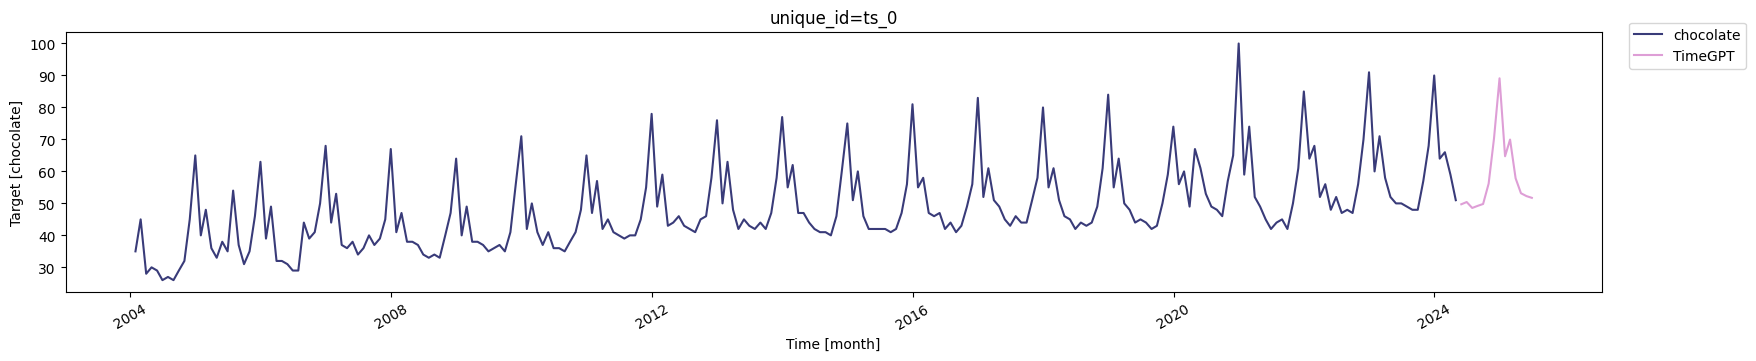

In [134]:
nixtla_client.plot(
    df_special,
    fcst_df_special,
    time_col="month",
    target_col="chocolate",
)

We can examine the feature importance to see how our custom special dates influence the chocolate interest forecasts:

<Axes: ylabel='features'>

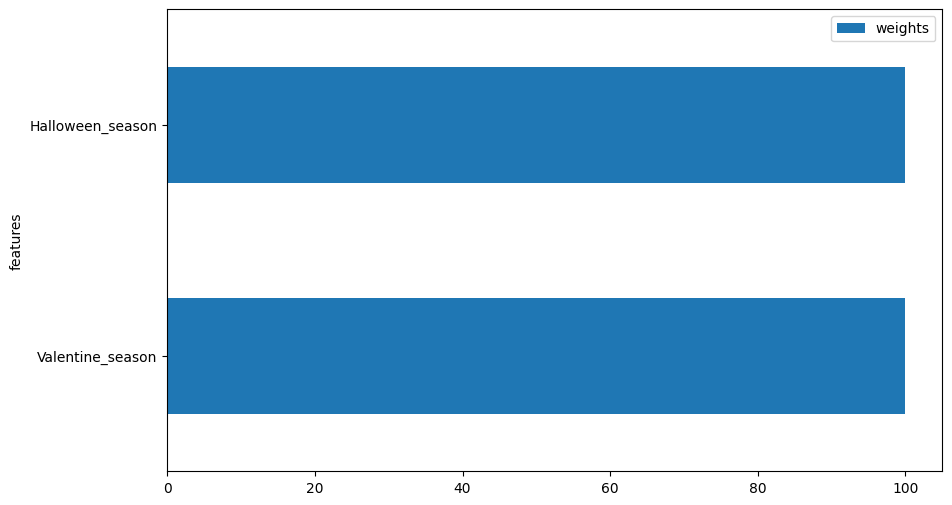

In [135]:
nixtla_client.weights_x.plot.barh(x="features", y="weights", figsize=(10, 6))

### SpecialDates vs CountryHolidays

The key differences between `SpecialDates` and `CountryHolidays` are:

- **CountryHolidays**: Uses predefined national holidays for specific countries. Perfect for capturing general seasonal patterns that affect entire populations.
- **SpecialDates**: Allows you to define completely custom dates specific to your business or use case. Ideal for company events, product launches, marketing campaigns, or any domain-specific significant dates.

Both can be used together to capture different types of temporal effects in your forecasting model.